In [30]:
import numpy as np
import pandas as pd
import copy
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import log_loss

In [44]:
# load raw financial data
# hourly resolution
gamestop_data = pd.read_csv('../foobar/data/raw/stock_candle_60_2020-03-01_2021-03-01.csv')
gamestop_data = gamestop_data.sort_values(by=['timestamp'], axis=0)
gamestop_data['datetime'] = pd.to_datetime(gamestop_data['timestamp'], unit='s')
gamestop_data = gamestop_data.set_index('datetime')

# resmaple the data hourly and pad the gaps with the previous record
gamestop_data = gamestop_data.resample('H', label='right').pad()
print(gamestop_data.shape)

train_data = gamestop_data[gamestop_data.index.year == 2020]
short_squeeze_data = gamestop_data[gamestop_data.index.year == 2021]
print(train_data.shape)
print(short_squeeze_data.shape)

train_data

(7692, 8)
(6395, 8)
(1297, 8)


,Unnamed: 0,close_price,high-price,low-price,open_price,status,timestamp,volume
datetime,,,,,,,,
2020-04-09 13:00:00,0,3.70,3.72,3.450,3.450,ok,1586437200,319130
2020-04-09 14:00:00,1,3.86,3.90,3.685,3.700,ok,1586440800,620809
2020-04-09 15:00:00,2,4.06,4.08,3.800,3.865,ok,1586444400,1023287
2020-04-09 16:00:00,3,4.12,4.19,3.890,4.060,ok,1586448000,602239
2020-04-09 17:00:00,4,4.03,4.25,3.870,4.130,ok,1586451600,1006734
...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,4,18.99,19.47,18.910,19.470,ok,1609441200,792064
2020-12-31 20:00:00,5,18.81,19.03,18.800,18.980,ok,1609444800,1081315
2020-12-31 21:00:00,6,18.80,18.95,18.290,18.840,ok,1609448400,1270488


## Data Preprocessing

In [45]:
# create train and test dataset
# sorted based on timestamp 

# extract timestamps for visualization
train_datetime_list = list(train_data.index)
test_datetime_list = list(short_squeeze_data.index)

# create a list of column names for training and predictions
cols = list(df_train)
# reordering the columns: put the prediction column to the last column
cols = ['open_price', 'high-price', 'low-price', 'volume','close_price']
df_train = train_data[cols]
df_target = short_squeeze_data[cols]

# check the df column types to ensure they have correct types
print(df_train.dtypes)
cols

open_price     float64
high-price     float64
low-price      float64
volume           int64
close_price    float64
dtype: object


['open_price', 'high-price', 'low-price', 'volume', 'close_price']

<AxesSubplot:xlabel='datetime'>

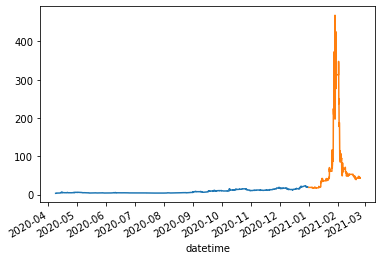

In [46]:
historical_data['close_price'].plot()
short_squeeze_data['close_price'].plot()

In [47]:
# finding missing values
df_train.isnull().sum()

open_price     0
high-price     0
low-price      0
volume         0
close_price    0
dtype: int64

In [48]:
df_target.isnull().sum()

open_price     0
high-price     0
low-price      0
volume         0
close_price    0
dtype: int64

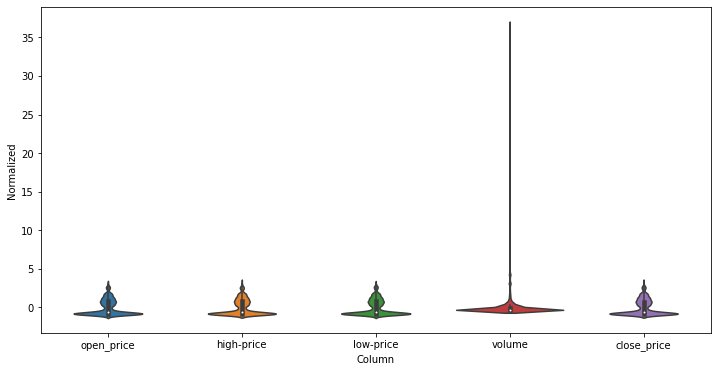

In [49]:
# Visualize the ditribution of the features in the train dataset
df_std = (df_train - df_train.mean()) / df_train.std()
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)


In [50]:
def scale(df_train, df_target, feature_set):
    sc = StandardScaler()
    train_arr = sc.fit_transform(df_train[feature_set])
    target_arr = sc.fit_transform(df_test[feature_set])
    return train_arr, target_arr

def split(train_arr, train_ratio):
    # split the data to train, validate
    n = len(train_arr)
    train_set = train_arr[:int(n*train_ratio)]
    val_set = train_arr[int(n*train_ratio):]
    return train_set, val_set

### Data Windowing for time series forecasting

> Refer to [Data Windowing](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing) for more details


In [15]:
# Generate time windows for time series forecasting with LSTM network
def generate_window(dataset, train_window, pred_horizon):
    dataset_seq = []
    size = len(dataset)
    x_arr = []
    y_arr = []
    for i in range(size - train_window - pred_horizon):
        x = dataset[i:(i+train_window), :-1]
        y = dataset[i+train_window+pred_horizon-1:i+train_window+pred_horizon, -1]
        x_arr.append(x)
        y_arr.append(y)
        dataset_seq.append((x, y))
    return np.array(x_arr), np.array(y_arr)

In [22]:
# various feature set for model selection
feature_set1 = ['open_price', 'high-price', 'low-price', 'volume', 'close_price']
feature_set2 = ['open_price', 'high-price', 'low-price', 'close_price']
feature_set3 = ['open_price', 'volume', 'close_price']
feature_set4 = ['volume', 'close_price']

train_set, target_set = scale(df_train, df_target, feature_set1)
train_set , val_set = split(train_set, 0.8)
# test set will be the dataset for short squeeze period
print(train_set.shape)
print(val_set.shape)
print(target_set.shape)

# let's create sequential training dataset with various traning windows and prediction horizons
# given that the times series data has 1-hour resolution
# 24hours * (days)
train_window_list = 24*[5, 10, 30]
prediction_horizon_list = 24*[1, 2, 3, 5, 10]

train_window = train_window_list[3]
prediction_horizon = prediction_horizon_list[0]

X_train, y_train = generate_window(train_set, train_window, prediction_horizon)
X_val, y_val = generate_window(val_set, train_window, prediction_horizon)
X_test, y_test = generate_window(target_set, train_window, prediction_horizon)

num_features = X_train.shape[2]

datetime_target = test_datetime_list[train_window+prediction_horizon:]

print(len(datetime_target))

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)



(5116, 5)
(1279, 5)
(2032, 5)
2026
torch.Size([5110, 5, 4])
torch.Size([5110, 1])
torch.Size([1273, 5, 4])
torch.Size([1273, 1])
torch.Size([2026, 5, 4])
torch.Size([2026, 1])


## Creating LSTM Network

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers = 2, output_size=1, seq_length=30):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.seq_len = seq_length
        
        self.hidden = None

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True
        )

        self.linear = nn.Linear(self.hidden_size * self.seq_len, self.output_size)

    def init_hidden(self, batch_size):
        hidden_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size)
        cell_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size)
        self.hidden = (hidden_state, cell_state)

    def forward(self, x, forecast_timesteps = 0):
        batch_size = x.shape[0]
        if self.hidden is None:
            self.init_hidden(batch_size)
        
        lstm_out, self.hidden = self.lstm(
                x,
                self.hidden
            )
        
        outputs = self.linear(lstm_out.reshape(batch_size,-1))

        return outputs


## Traning LSTM model

In [25]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTM(seq_length=train_window, input_size=num_features).to(device)

def train_model(model, train_dataset, val_dataset=None, num_epochs)
    X_train, y_train = train_dataset
    if val_dataset is not None:
        X_val, y_val = val_dataset

    learning_rate = 1e-3
    best_loss = np.Inf
    val_loss = None
    history = dict(train=[], val=[])
    train_window = X_train.shape[1]
    num_features = X_train.shape[2]

    criterion = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        X_train.to(device)
        model.init_hidden(X_train.shape[0])
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss = loss.item()

        if val_dataset is not None:
            with torch.no_grad():
                model.eval()
                X_val.to(device)
                model.init_hidden(X_val.shape[0])
                pred = model(X_val)
                loss = criterion(pred, y_val)
                val_loss = loss.item()
                
            history['val'].append(val_loss)
            if val_loss < best_loss:
                best_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    history['train'].append(train_loss)
   

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    if val_loss < 0.05:
        break

# model.load_state_dict(best_model_wts)


Epoch 0: train loss 0.5873175859451294 val loss 2.71575927734375
Epoch 1: train loss 0.5549534559249878 val loss 2.7537379264831543
Epoch 2: train loss 0.5250667929649353 val loss 2.7896065711975098
Epoch 3: train loss 0.4969106912612915 val loss 2.821897268295288
Epoch 4: train loss 0.4695743918418884 val loss 2.8487911224365234
Epoch 5: train loss 0.4425090253353119 val loss 2.86826229095459
Epoch 6: train loss 0.41505077481269836 val loss 2.8781957626342773
Epoch 7: train loss 0.3868694007396698 val loss 2.8763725757598877
Epoch 8: train loss 0.3584003150463104 val loss 2.860069990158081
Epoch 9: train loss 0.3302381634712219 val loss 2.825667381286621
Epoch 10: train loss 0.3025261163711548 val loss 2.767739772796631
Epoch 11: train loss 0.27797508239746094 val loss 2.678617238998413
Epoch 12: train loss 0.25722676515579224 val loss 2.552276134490967
Epoch 13: train loss 0.24164491891860962 val loss 2.3909876346588135
Epoch 14: train loss 0.22945506870746613 val loss 2.206057071685

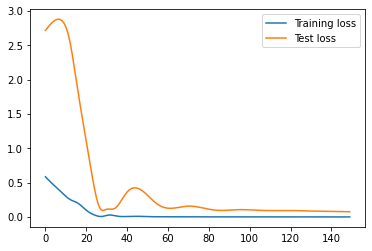

In [26]:

plt.plot(history['train'], label="Training loss")
plt.plot(history['val'], label="Test loss")
plt.legend()

## Predictions

In [27]:
predictions, losses = [], []
criterion = nn.L1Loss(reduction='sum').to(device)

with torch.no_grad():
    model.eval()
    for i in range(X_test.shape[0]):
        x_i = X_test[i:i+1]
        y_i = y_test[i:i+1]
        x_i.to(device)
        model.init_hidden(x_i.shape[0])
        y_pred = model(x_i)
        predictions.append(y_pred.cpu().numpy().flatten())
        loss = criterion(y_pred, y_i)
        losses.append(loss.item())

truth = y_test.cpu().numpy().flatten()
predictions = np.array(predictions).flatten()

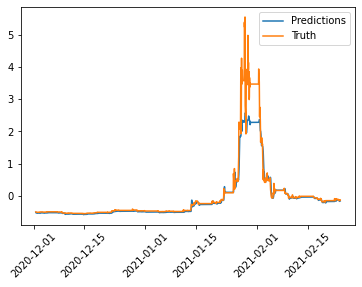

In [28]:

plt.plot(datetime_target,predictions, label="Predictions")
plt.plot(datetime_target, truth, label="Truth")
plt.xticks(rotation=45)
plt.legend()

0.6003553915909061

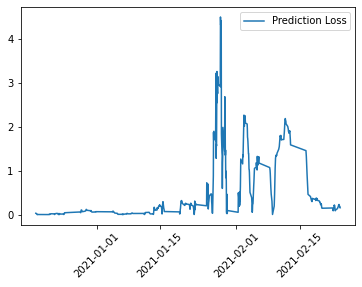

In [275]:
plt.plot(datetime_target ,losses, label="Prediction Loss")
plt.xticks(rotation=45)
plt.legend()
np.mean(losses)